# Create WecOptTool Model for the Marson WEC concept

In [20]:
import numpy as np
import capytaine as cpt
from capytaine.io.meshio import load_from_meshio
import matplotlib.pyplot as plt
from scipy.optimize import brute
import pygmsh
import os
from xarray import Dataset

## set colorblind-friendly colormap for plots
plt.style.use('tableau-colorblind10')

import logging
logging.getLogger().setLevel(logging.INFO)

In [ ]:
def change_draft(draft):

    z_cg = 3 - draft # 3 m above the bottom of the sphere

    mesh = cpt.mesh_sphere(radius=5.0, center=(0, 0, z_cg), resolution=(100, 100))

    #meshObj = load_from_meshio(rectMesh, 'Rect')
    lid_pos = mesh.lowest_lid_position(8.4) # add lid to reduce irregular frequency peaks
    print(lid_pos)
    lid_mesh = mesh.generate_lid(z=lid_pos)

    rigid_sphere = cpt.FloatingBody(mesh, lid_mesh = lid_mesh, center_of_mass=(0, 0, z_cg)).immersed_part()
    rigid_sphere.rotation_center = rigid_sphere.center_of_mass
    rigid_sphere.add_all_rigid_body_dofs()

    solver = cpt.BEMSolver()
    test_matrix = Dataset(coords={
        'rho': [rho],
        'water_depth': [depth],
        'omega': [ifreq*2*np.pi for ifreq in freq],
        'wave_direction': wave_dirs,
        'radiating_dof': list(rigid_sphere.dofs.keys()),
        'g': [g],
    })

    bem_data = solver.fill_dataset(test_matrix, rigid_sphere)

    

In [ ]:
mesh = cpt.mesh_sphere(radius=5.0, center=(0, 0, -2), resolution=(100, 100))

#meshObj = load_from_meshio(rectMesh, 'Rect')
lid_pos = mesh.lowest_lid_position(8.4) # add lid to reduce irregular frequency peaks
print(lid_pos)
lid_mesh = mesh.generate_lid(z=lid_pos)

rigid_sphere = cpt.FloatingBody(mesh, lid_mesh = lid_mesh,center_of_mass=(0, 0, -2)).immersed_part()
rigid_sphere.rotation_center = rigid_sphere.center_of_mass
rigid_sphere.add_all_rigid_body_dofs()

rigid_sphere.show_matplotlib()
#rigid_sphere.show()

# set frequencies
wCapy =  np.linspace(0.02, 8.4, 42)                  # wave frequencies
freq = wCapy/(2*np.pi)

rho = 1000
g = 9.81
depth = 50
wave_dirs = 0

-0.12531700850588012


In [22]:


solver = cpt.BEMSolver()
test_matrix = Dataset(coords={
    'rho': [rho],
    'water_depth': [depth],
    'omega': [ifreq*2*np.pi for ifreq in freq],
    'wave_direction': wave_dirs,
    'radiating_dof': list(rigid_sphere.dofs.keys()),
    'g': [g],
})

bem_data = solver.fill_dataset(test_matrix, rigid_sphere)

[13:54:24] WARNING  Mesh resolution for 63 problems:                                                               
                    The resolution of the mesh might be insufficient for omega ranging from 6.765 to 8.400.        
                    This warning appears when the largest panel of this mesh has radius > wavelength/8.

Output()

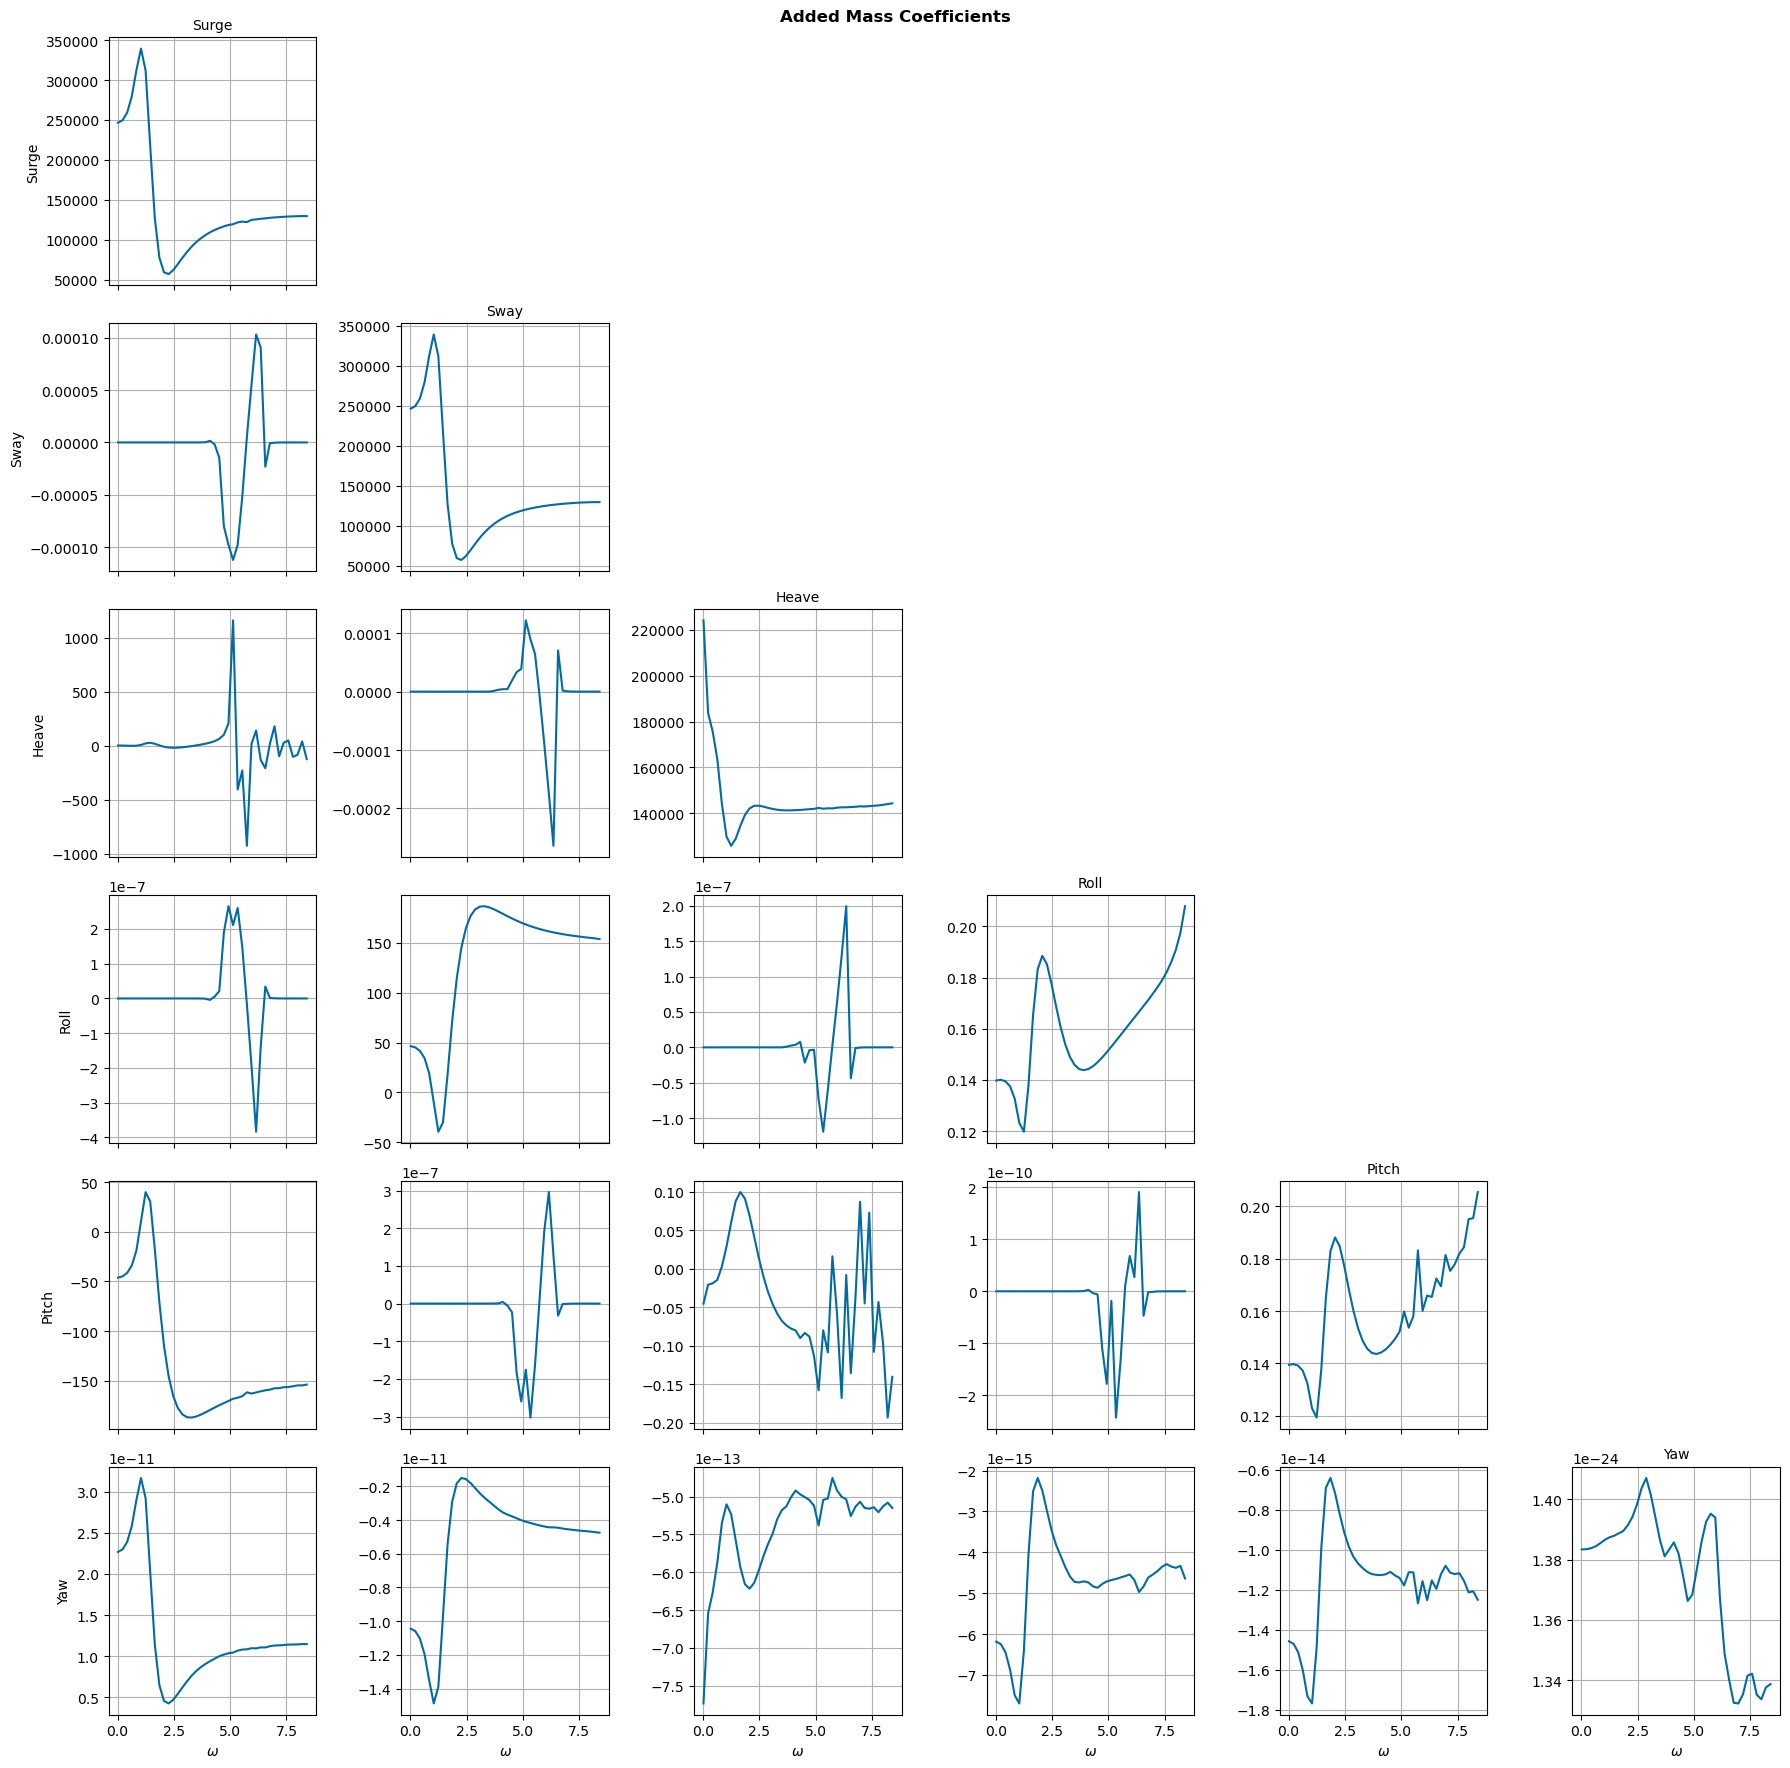

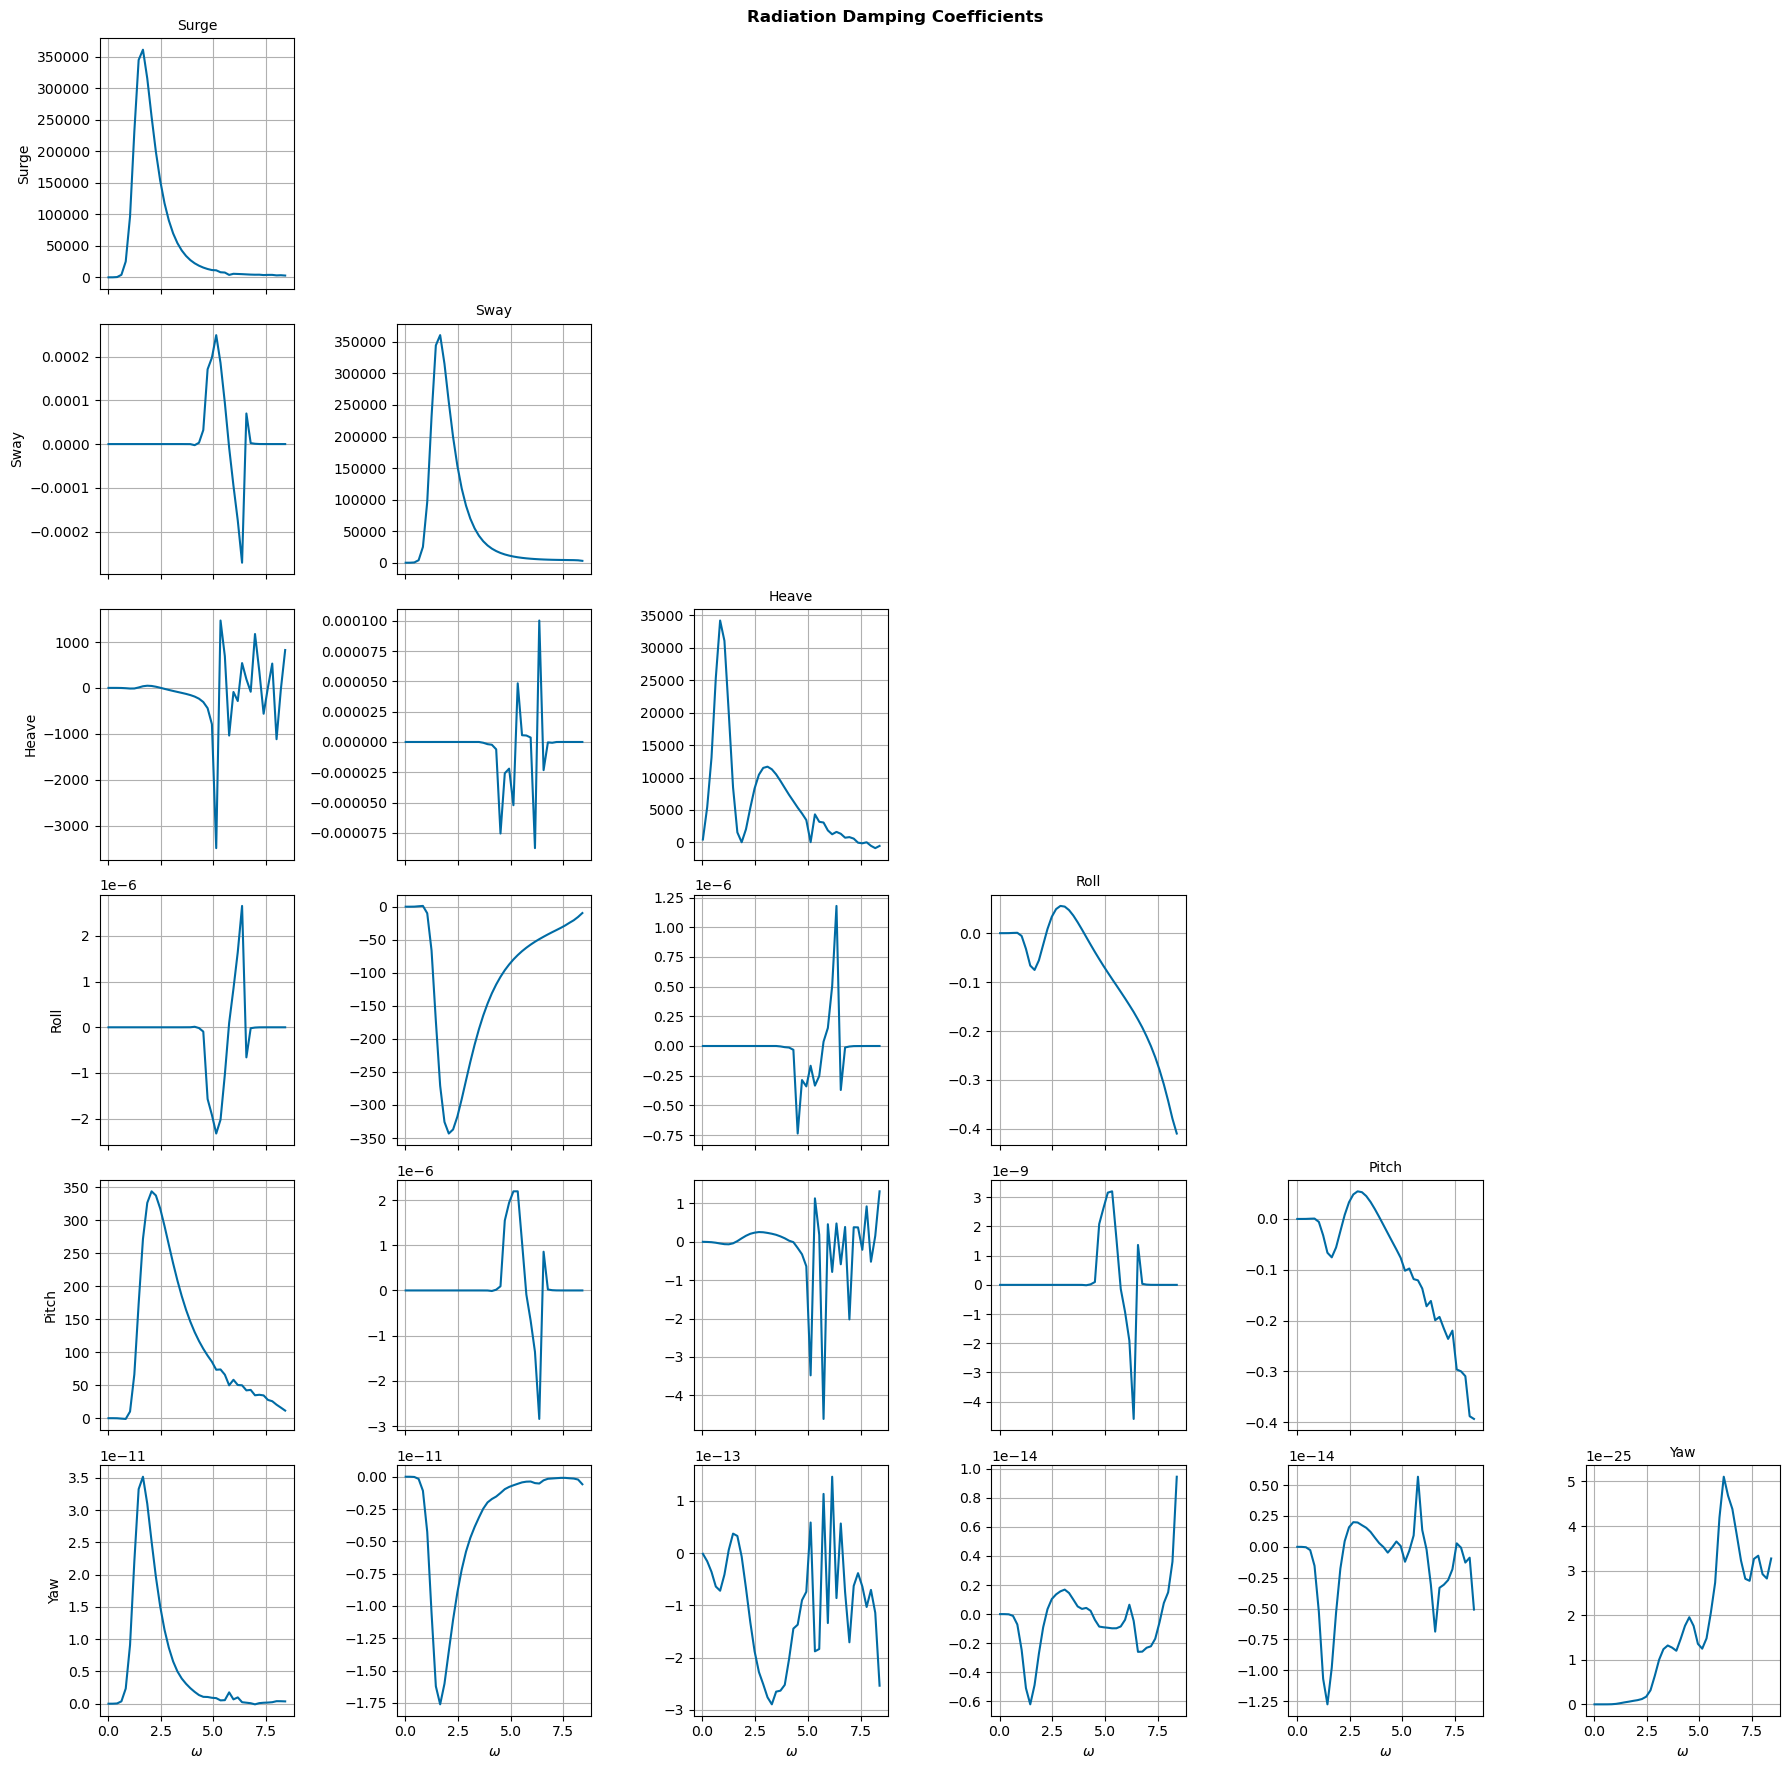

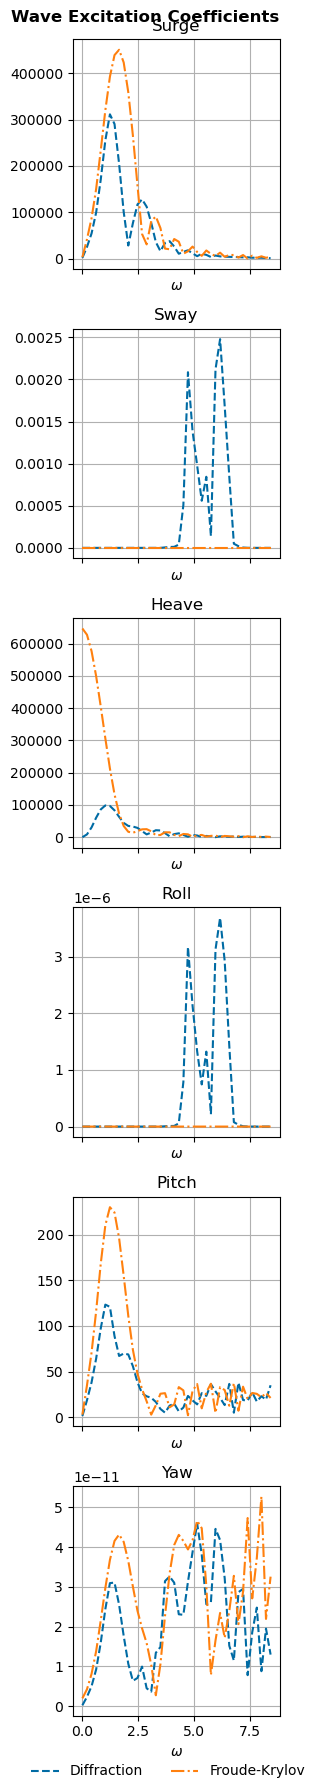

In [23]:
bem_data_sel = bem_data.sel(wave_direction = 0, method='nearest')
radiating_dofs = bem_data_sel.radiating_dof.values
influenced_dofs = bem_data_sel.influenced_dof.values

# plots
fig_am, ax_am = plt.subplots(
    len(radiating_dofs), 
    len(influenced_dofs),
    tight_layout=True, 
    sharex=True, 
    figsize=(3*len(radiating_dofs),3*len(influenced_dofs)),
    squeeze=False
    )
fig_rd, ax_rd = plt.subplots(
    len(radiating_dofs),
    len(influenced_dofs),
    tight_layout=True,
    sharex=True, 
    figsize=(3*len(radiating_dofs), 3*len(influenced_dofs)),
    squeeze=False
    )
fig_ex, ax_ex = plt.subplots(
    len(influenced_dofs),
    1,
    tight_layout=True, 
    sharex=True, 
    figsize=(3, 3*len(radiating_dofs)), 
    squeeze=False
    )
[ax.grid(True) for axs in (ax_am, ax_rd, ax_ex) for ax in axs.flatten()]
# plot titles
fig_am.suptitle('Added Mass Coefficients', fontweight='bold')
fig_rd.suptitle('Radiation Damping Coefficients', fontweight='bold')
fig_ex.suptitle('Wave Excitation Coefficients', fontweight='bold')

sp_idx = 0
for i, rdof in enumerate(radiating_dofs):
    for j, idof in enumerate(influenced_dofs):
        sp_idx += 1
        if i == 0:
            np.abs(bem_data_sel.diffraction_force.sel(influenced_dof=idof)).plot(
                ax=ax_ex[j,0], linestyle='dashed', label='Diffraction')
            np.abs(bem_data_sel.Froude_Krylov_force.sel(influenced_dof=idof)).plot(
                ax=ax_ex[j,0], linestyle='dashdot', label='Froude-Krylov')
            ex_handles, ex_labels = ax_ex[j,0].get_legend_handles_labels()
            ax_ex[j,0].set_title(f'{idof}')
            ax_ex[j,0].set_xlabel('')
            ax_ex[j,0].set_ylabel('')
        if j <= i:
            bem_data_sel.added_mass.sel(
                radiating_dof=rdof, influenced_dof=idof).plot(ax=ax_am[i, j])
            bem_data_sel.radiation_damping.sel(
                radiating_dof=rdof, influenced_dof=idof).plot(ax=ax_rd[i, j])
            if i == len(radiating_dofs)-1:
                ax_am[i, j].set_xlabel(f'$\omega$', fontsize=10)
                ax_rd[i, j].set_xlabel(f'$\omega$', fontsize=10)
                ax_ex[j, 0].set_xlabel(f'$\omega$', fontsize=10)
            else:
                ax_am[i, j].set_xlabel('')
                ax_rd[i, j].set_xlabel('')
            if j == 0:
                ax_am[i, j].set_ylabel(f'{rdof}', fontsize=10)
                ax_rd[i, j].set_ylabel(f'{rdof}', fontsize=10)
            else:
                ax_am[i, j].set_ylabel('')
                ax_rd[i, j].set_ylabel('')
            if j == i:
                ax_am[i, j].set_title(f'{idof}', fontsize=10)
                ax_rd[i, j].set_title(f'{idof}', fontsize=10)
            else:
                ax_am[i, j].set_title('')
                ax_rd[i, j].set_title('')
        else:
            fig_am.delaxes(ax_am[i, j])
            fig_rd.delaxes(ax_rd[i, j])
fig_ex.legend(ex_handles, ex_labels, loc=(0.08, 0), ncol=2, frameon=False)